In [1]:
#public data integration
import os
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import anndata as ad
import scanpy as sc
import os
import pandas as pd
import numpy as np
import useful_functions as uf
import scvi
sc.set_figure_params(figsize=(6, 6))
import sys
print(sys.executable)
import matplotlib as mpl
import matplotlib.pyplot as plt


/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0


/home/jovyan/my-conda-envs/myenv/bin/python


/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(pd.__version__)
print(scvi.__version__)
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')


1.9.1
0.8.0
1.5.1
0.19.0


In [3]:
#read this raw adata
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data')
stewart = sc.read_h5ad("./public_data/stewart_2019/stewart_remap_raw.h5ad")
kuppe = sc.read_h5ad("./public_data/kuppe_2021/kuppe_adata.h5ad")
kpmp = sc.read_h5ad("./public_data/kpmp_2022/kpmp.h5ad")
li = sc.read_h5ad("./public_data/li_2022/li_adata.h5ad")
he = sc.read_h5ad("./public_data/he_2021/he_adata.h5ad")

In [4]:
#sort out metadata
kpmp.obs['dataset'] = 'kpmp'
kpmp.obs['annotated_celltype'] = 'unknown'
kpmp.obs['channel'] = kpmp.obs['orig.ident']
kpmp.obs['technology'] = '3prime'
kpmp.obs['donor'] = kpmp.obs['SpecimenID']

kuppe.obs['dataset'] = 'kuppe'
kuppe.obs['annotated_celltype'] = 'unknown'
kuppe.obs['channel'] = kuppe.obs['Experiment']
kuppe.obs['donor'] = kuppe.obs['Experiment']
kuppe.obs['technology'] = '3prime'

stewart.obs['dataset'] = 'stewart'
stewart.obs['technology'] = '3prime'
stewart.obs['celltype'] = stewart.obs['annotated_celltype']
stewart.layers['counts'] = stewart.layers['denoised_counts']

li.obs['channel'] = li.obs['orig.ident']
li.obs['dataset'] = 'li'
li.obs['annotated_celltype'] = 'unknown'
li.obs['technology'] = '5prime'
li.obs['celltype'] = li.obs['broad_type']
li.obs['donor'] = li.obs['patient']

In [5]:
celltype_map = {'Arterioral Endothelium': 'arterial_endothelium',
'Ascending vasa recta endothelium' : 'VR_endothelium',
'EC' : 'peritubular_capillary_endothelium',
'Fibro' : 'fibroblast',
'B-cell' : 'B_cell',
'B' : 'B_cell',
'B Cells' : 'B_cell',
'B cell' : 'B_cell',
'Basophils' : 'mast_cell',
'Mast' : 'mast_cell',
'C-TAL' : 'TAL_LOH',
'CD4 T cell': 'CD4_T_cell',
'CD8 T cell' : 'CD8_T_cell',
'CNT' : 'CNT', 
'CNT-IC-A' : 'IC_A',
'CNT-PC' : 'PC',
'Collecting Duct Principal Cells' : 'PC',
'Connecting Tubule' : 'CNT',
'Connecting tubule' : 'CNT',
'DCT1' : 'DCT',
'DTL1' : 'DTL_LOH',
'Dendritic Cells' : 'DC',
'Descending Thin Limb' : 'DTL_LOH',
'Descending vasa recta endothelium' : 'VR_endothelium',
'Distal Convoluted Tubule' : 'DCT',
'Distinct proximal tubule 1' : 'PTEC',
'Distinct proximal tubule 2' : 'PTEC',
'EC-AEA' : 'arterial_endothelium' ,
'EC-GC'  : 'glomerular_endothelium',
'EC-LYM' : 'lymphatic_endothelium',
'EC-PTC' : 'peritubular_capillary_endothelium',
'Epithelial progenitor cell' : 'DTL_LOH',
'Epi_PT' : 'PTEC',
'FIB' : 'fibroblast',
'Fibroblast' : 'fibroblast',
'Glomerular Capillaries' : 'glomerular_endothelium',
'Glomerular endothelium' : 'glomerular_endothelium',
'IC-A' : 'IC_A', 
'IC-B' : 'IC_B',
'Indistinct intercalated cell' : 'IC',
'Injured Endothelium' : 'peritubular_capillary_endothelium',
'Injured Tubule' : 'PTEC',
'Intercalated Cells' : 'IC',
'Lymph Endothelium': 'lymphatic_endothelium',
'T-cell' : 'T_cell',
'M-TAL' : 'TAL_LOH',
'MAC-M2' : 'macrophage',
'MC' : 'mesangial_cell',
'MDC' : "DC",
'MNP-a/classical monocyte derived' : 'MNP',
'MNP-b/non-classical monocyte derived' : 'MNP',
'MNP-c/dendritic cell' : 'DC',
'MNP-d/Tissue macrophage' : 'MNP',
'MON' : 'MNP',
'MAST' : 'mast_cell',
'Macrophages' : 'MNP',
'Mast cell' : 'mast_cell',
'Monocytes' : 'MNP', 
'MyoF' : 'myofibroblast',
'Myofibroblast' : 'myofibroblast',
'Myeloid' : 'MNP',
'NK' : 'NK_cell', 
'NK cell' : 'NK_cell',
'NK1' : 'NK_cell',
'NK2' : 'NK_cell',
'NKT' : 'NKT_cell',
'NKT cell' : 'NKT_cell',
'Natural Killer Cells' : 'NK_cell',
'Neutrophil' : 'neutrophil',
'PC' : 'PC',
'PEC' : 'GPEC',
'PL' : 'plasma_cell',
'POD' : 'podocyte',
'PT-S1/S2' : 'PTEC',
'PT-S3' : 'PTEC',
'Pelvic epithelium' : 'pelvic_epithelium',
'Pericytes' : 'vascular_smooth_muscle_cell',
'Peritubular capillary endothelium 1' : 'peritubular_capillary_endothelium',
'Peritubular capillary endothelium 2' : 'peritubular_capillary_endothelium',
'Plasma Cells' : 'plasma_cell',
'Plasma' : 'plasma_cell',
'Plasmacytoid dendritic cell' : 'pDC',
'pDC' : 'pDC',
'Podocyte' : 'podocyte',
'Podocytes' : 'podocyte',
'Principal cell' : 'PC',
'Proliferating Proximal Tubule' : 'PTEC',
'Proximal Tubule' : 'PTEC',
'Proximal tubule' : 'PTEC',
'REN' : 'renin_cell',
'Schwann Cells' : 'schwann_cell',
'Smooth Muscle Cells' : 'vascular_smooth_muscle_cell',
'T' : 'T_cell',
'T Cells' : 'T_cell',
'T-CYT' : 'CD8_T_cell',
'T-REG' : 'CD4_T_cell',
'Thick Ascending Limb' : 'TAL_LOH',
'Thick ascending limb of Loop of Henle' : 'TAL_LOH',
'Transitional urothelium' : "urothelial_cell",
'Type A intercalated cell' : 'IC_A',
'Type B intercalated cell' : 'IC_B',
'Uroethlial Cells' : 'urothelial_cell',
'VSMC/P' : 'vascular_smooth_muscle_cell',
'Vasa Recta'  : 'VR_endothelium',
'Venular Endothelium' : 'venous_endothelium',
'aFIB' : 'fibroblast',
'aPT' : 'PTEC',
'aTAL1' : 'TAL_LOH',
'aTAL2' : 'TAL_LOH',
'cDC': 'DC', 
'cycEC' : 'peritubular_capillary_endothelium',
'cycEPI' : 'PTEC',
'cycMNP' : 'MNP',
'cycT' : 'T_cell',
'dC-TAL' : 'TAL_LOH',
'dCNT' : 'CNT',
'Epi_non-PT' : 'IC_A', #most of these cells are IC-A
'dCNT-PC'  : "PC",
'dDCT' : 'DCT',
'dEC-PTC' : 'PTEC',
'dIC-A' : 'IC_A',
'dPC' : 'PC',
'dPT' : 'PTEC',
'dPT/DTL' : 'DTL_LOH',
'dVSMC' : 'vascular_smooth_muscle_cell',
'ncMON': "MNP",
'pDC'  : 'pDC',
'tPC-IC' : 'IC'}

In [6]:
#get QC metrics
def get_qc_metrics(adata):
    adata.var['Symbol'] = adata.var_names.values
    adata.var['MT'] = [gene.startswith('MT-') for gene in adata.var['Symbol']]
    sc.pp.calculate_qc_metrics(adata, qc_vars= ["MT"], inplace = True)
    return(adata)

In [7]:
#calculate dissociation stress score
def calculate_stress_score(adata, stress_genes):
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.tl.score_genes(adata, gene_list = vdb_genes, score_name='dissociation_stress_score')
    dissociation_score  = adata.obs['dissociation_stress_score']
    return(dissociation_score)

In [8]:
vdb_genes = ['SOCS3', 'ATF3', 'CEBPB', 'JUND', 'HSPE1', 'CEBPD', 'ZFP36', 'FOSB', 'JUNB', 
             'HSP90AA1', 'EGR1', 'HSPB1','HSPA8','HSP90AB1','JUN','FOS', 'HSPA1A', 'HSPA1B']
kpmp.obs['dissociation_stress_score'] = calculate_stress_score(kpmp, vdb_genes)
kpmp = get_qc_metrics(kpmp)
kuppe.obs['dissociation_stress_score'] = calculate_stress_score(kuppe, vdb_genes)
kuppe = get_qc_metrics(kuppe)
stewart.obs['dissociation_stress_score'] = calculate_stress_score(stewart, vdb_genes)
stewart = get_qc_metrics(stewart)
li.obs['dissociation_stress_score'] = calculate_stress_score(li, vdb_genes)
li = get_qc_metrics(li)

In [9]:
#get the core exclude regex like we did in 2019
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/public_data/stewart_2019')
core_exclude =  np.array(pd.read_csv("./core_exclude_genes.txt", header = None)[0])
stewart = stewart[:,core_exclude]

In [10]:
adata = sc.concat([stewart, kuppe, kpmp, li])

In [11]:
adata.var['Symbol'] = adata.var_names.values #make symbols

In [12]:
adata.layers['counts'] = adata.X

In [13]:
#harmonise cell type labels
# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['harmonised_celltype'] = adata.obs['celltype'].map(celltype_map).astype('category')

In [14]:
adata #take a look

AnnData object with n_obs × n_vars = 171590 × 14489
    obs: 'channel', 'annotated_celltype', 'donor', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'dataset', 'technology', 'celltype', 'dissociation_stress_score', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'harmonised_celltype'
    var: 'Symbol'
    layers: 'counts'

In [15]:
#call highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes = 1500, flavor='seurat_v3', 
                            batch_key = 'dataset', subset = False, layer = 'counts')
print(adata.var['highly_variable'].value_counts())

False    12989
True      1500
Name: highly_variable, dtype: int64


In [16]:
adata.uns['raw_adata'] = adata.copy() #this lets us get the rawcounts later

In [17]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [18]:
adata.raw = adata.copy()

In [19]:
#run PCA
sc.pp.pca(adata)

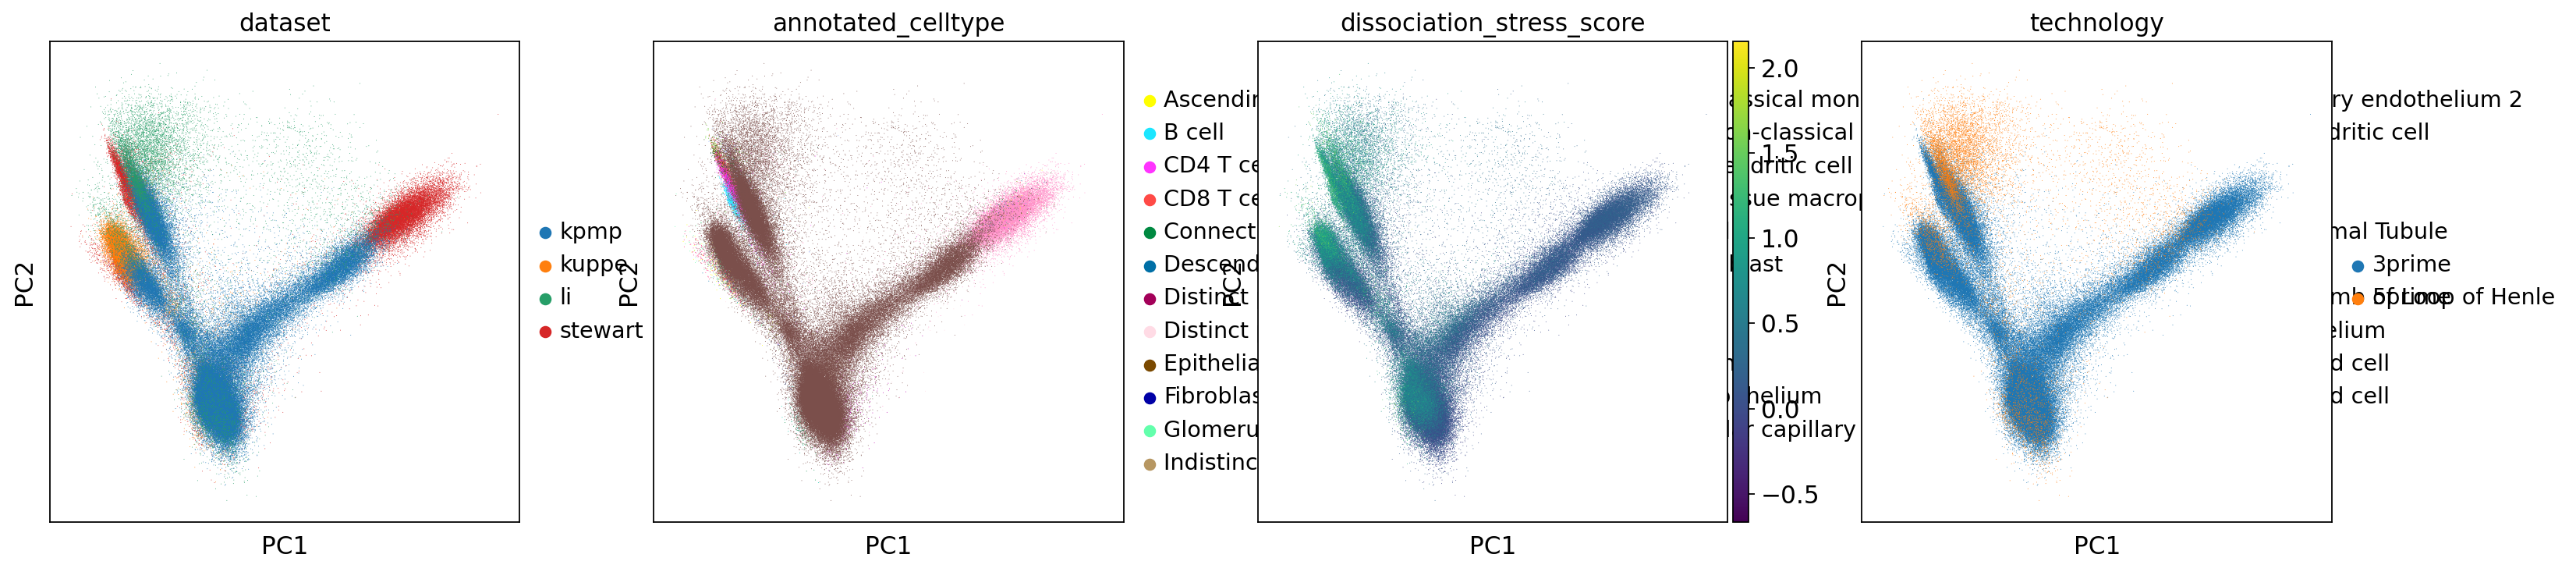

In [20]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    sc.pl.pca(adata, color = ['dataset', 'annotated_celltype', 'dissociation_stress_score', 'technology'])

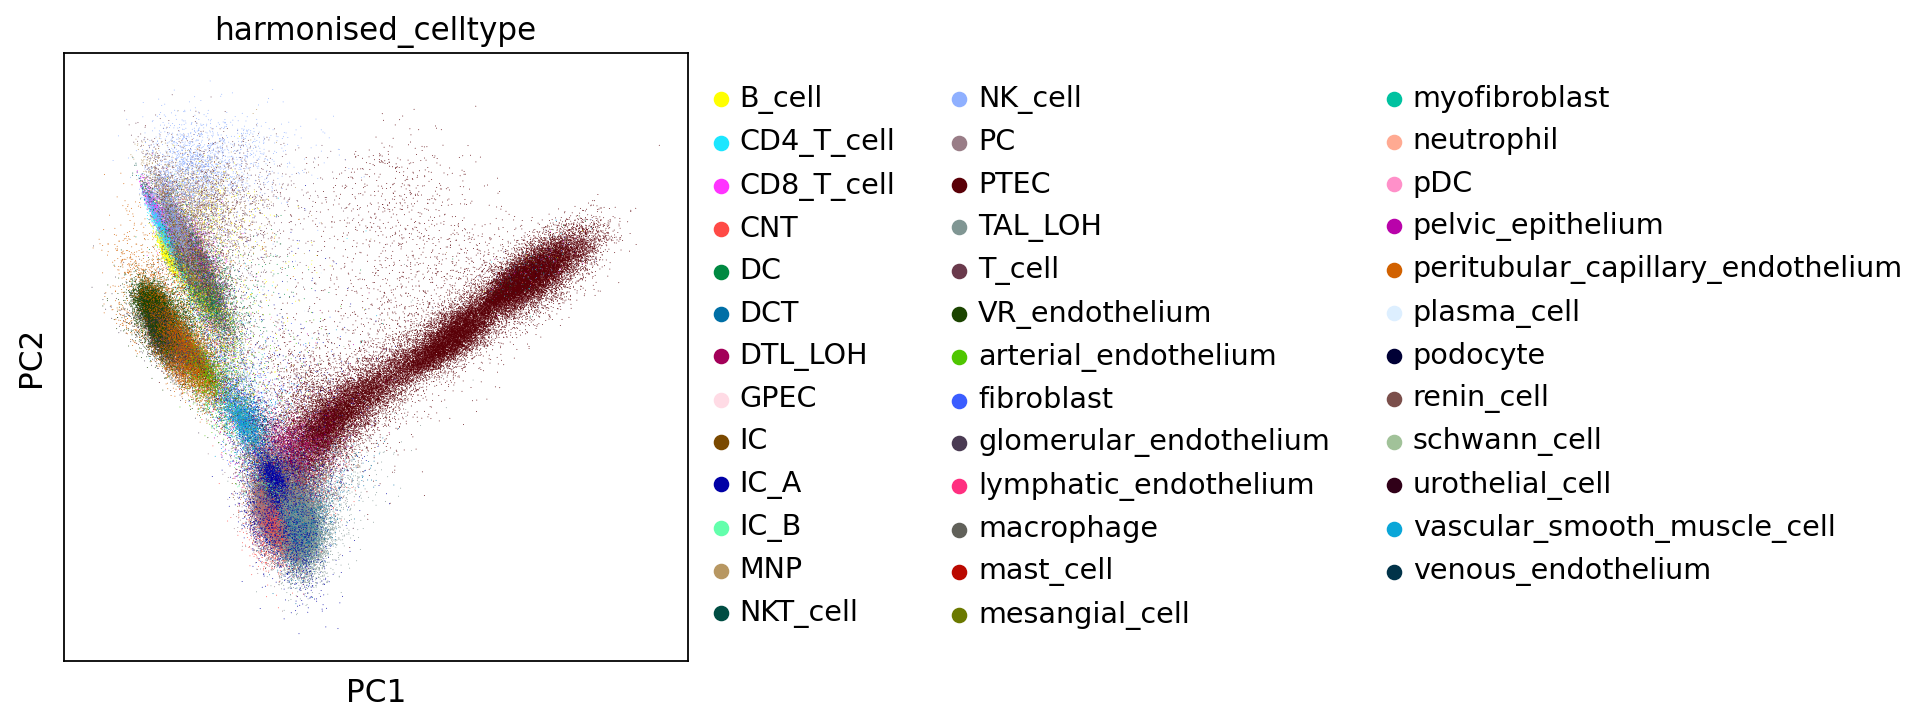

In [21]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    sc.pl.pca(adata, color = ['harmonised_celltype'])

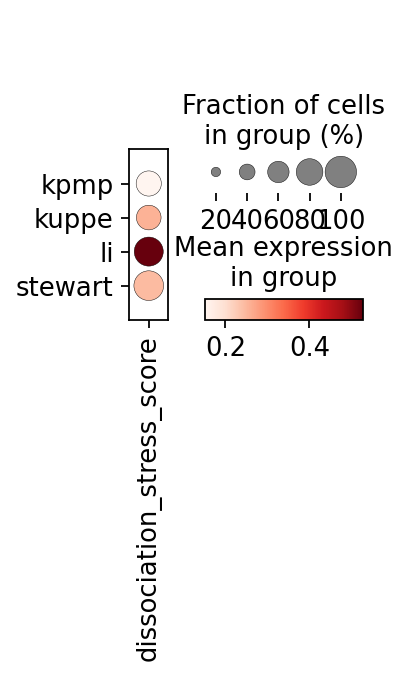

In [22]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [2, 2]}):
    sc.pl.dotplot(adata, groupby = 'dataset', var_names = 'dissociation_stress_score')

In [23]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/raw/public_data')

In [24]:
adata.write("./public_kidney_adata.h5ad")